In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pprint

In [2]:
"""
TODOs:
    solve for displacements of a 2D truss system where each truss has only one element

    create TrussElement2D(node_indeces, E,A,L, f=[0,0,0,0], theta = 0)
        - k_elem 4x4


"""

'\nTODOs:\n    solve for displacements of a 2D truss system where each truss has only one element\n\n    create TrussElement2D(node_indeces, E,A,L, f=[0,0,0,0], theta = 0)\n        - k_elem 4x4\n\n\n'

In [3]:
# class Node:
#     def __init__(self, index):
#         self.index = index
#         self.coordinates = None

# # TODO: Should I use node coordinates for a node or can i get

In [113]:
class TrussElement2D:
    def  __init__(self, node_indeces, node_coordinates, E,A,L, distributed_load = 0, f_applied=[0,0,0,0], theta = 0, shape_function = "linear"):
        self.node_indeces = node_indeces
        self.node_coordinates = node_coordinates
        self.E = E
        self.A = A
        self.L = L
        self.q = distributed_load
        self.f_applied = np.array(f_applied) # not necessary for current algorithm
        self.theta = theta # from (right) to (up)
        self.shape_function = shape_function

        if self.shape_function != "linear":
            raise NotImplementedError("Only linear shape functions are implemented")
        if self.q != 0:
            raise NotImplementedError("Distributed loads are not implemented")


        # self.get_local_stiffness_matrix()
        # self.get_global_stiffness_matrix()

    def get_local_stiffness_matrix(self):
        # returns the stiffness matrix for the element in local coordinates
        k  = self.E*self.A/self.L
        self.k_elem_local = k * np.array([[1,0,-1,0],[0,0,0,0],[-1,0,1,0],[0,0,0,0]])

    def get_global_stiffness_matrix(self):
        self.get_local_stiffness_matrix()
        # returns the global stiffness matrix for the element in global coordinates
        S = np.sin(np.deg2rad(self.theta))
        C = np.cos(np.deg2rad(self.theta))
        R = np.array([[C, S],
                      [-S, C]])
        T = np.array([[C,S,0,0],
                      [-S,C,0,0],
                      [0,0,C,S],
                      [0,0,-S,C]])
        self.K_elem_global = T.T @ self.k_elem_local @ T
        return self.K_elem_global

    def get_local_load_vector(self):
        pass

    def get_global_load_vector(self):
        pass


In [110]:
class TrussSystem2D:
    def __init__(self, elements, num_nodes, forces, boundary_conditions):
        self.elements = elements
        self.num_nodes = num_nodes
        self.forces = forces
        self.boundary_conditions = boundary_conditions

    # def get_node_coordinates(self):
    #     origin = [0,0]

    #     for element in self.elements:
    #         for node_index in element.node_indeces:
    #             if node_index == 0:
    #                 node_coordinates = origin



In [140]:
class Solver:
    def __init__(self, system):
        self.system = system

    def solve(self):
        self.assemble_global_matrices()
        self.apply_boundary_conditions()

    def assemble_global_matrices(self):
        # Assemble global stiffness
        self.K_global = np.zeros((self.system.num_nodes*2, self.system.num_nodes*2)) # multiply by 2 cause for a node 2 is the DoF hence it's 2D

        for element in self.system.elements:
            K_elem = element.get_global_stiffness_matrix()
            node_per_element = len(self.system.elements[0].node_indeces) # 2 for linear

            # Get the global DOF indices for the element's nodes
            global_dof_indices = []
            for node_index in element.node_indeces:
                global_dof_indices.extend([2 * node_index, 2 * node_index + 1])  # DOFs: x, y

            for i in range(len(global_dof_indices)):
                for j in range(len(global_dof_indices)):
                    self.K_global[global_dof_indices[i], global_dof_indices[j]] += K_elem[i, j]

        # Assemble load vector
        self.F_global = np.zeros((self.system.num_nodes*2))
        for node_index, f_x, f_y in self.system.forces:
            global_dof_index = int(2 * node_index)
            self.F_global[global_dof_index] += f_x
            self.F_global[global_dof_index + 1] += f_y

        return self.K_global, self.F_global

    def apply_boundary_conditions(self):
        known_global_indeces = []
        for node_index, constraint_x, constraint_y in self.system.boundary_conditions:
            global_dof_index = int(2 * node_index)
            if constraint_x == 1:
                known_global_indeces.append(global_dof_index)
            if constraint_y == 1:
                known_global_indeces.append(global_dof_index + 1)

        # get the matrix while remowing the indeces in known global indeces
        self.Kuu = np.delete(np.delete(self.K_global, known_global_indeces, axis=0), known_global_indeces, axis=1)
        self.Fuu = np.delete(self.F_global, known_global_indeces, axis=0)

        return self.Kuu, self.Fuu

    def solve_displacements(self):
        pass

    def calculate_stresses(self):
        pass


In [141]:
class Plotter:
    def __init__(self, system):
        self.system = system

    def plot_system(self):
        """
        plots the truss system
        """
        for element in self.system.elements:
            pos1, pos2 = element.node_coordinates
            x1, y1 = pos1
            x2, y2 = pos2
            plt.plot([x1,x2], [y1,y2])
        plt.show()


In [142]:
E = 100*10^3; A = 625; L=2000; # for each truss element, [units: N, mm, MPa]

connectivity = np.array([[0,1], [0,2], [1,2], [1,3], [2,3], [2,4], [3,4]])
nodal_coordinates = np.array([[0,0], [0,L], [L,0], [L,L], [2*L,0]])
angles_of_elements = np.array([90,0,135,0,90,0,135])

# node_index, constraint_x, constraint_y
boundary_conditions = np.array([
                            [0,1,0],
                            [1,1,1]])

 # node_index, f_x, f_y
forces = np.array([
                [0, 100e3, 0], # reaction 1
                [1, -200e3, 100e3], # reaction 2
                [4, 10e3, -10e3]])  # applied force

num_nodes = (np.max(connectivity) + 1)
elements = []
for i, node_indeces in enumerate(connectivity):
    node_coordinates = nodal_coordinates[node_indeces]
    element = TrussElement2D(node_indeces, node_coordinates, E,A,L, f_applied=[0,0,0,0], theta = angles_of_elements[i])
    elements.append(element)

system = TrussSystem2D(elements, num_nodes, forces, boundary_conditions)


In [144]:
solver = Solver(system)
solver.assemble_global_matrices()
Kuu, Fuu = solver.apply_boundary_conditions()
Kuu.shape, Fuu.shape

((7, 7), (7,))

In [115]:
solver = Solver(system)
solver.solve()

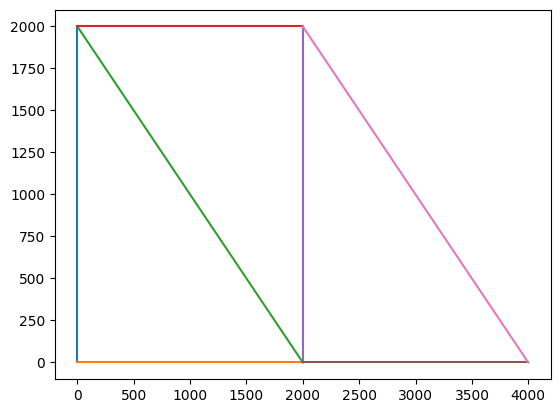

In [39]:
plotter = Plotter(system)
plotter.plot_system()


AttributeError: 'TrussElement2D' object has no attribute 'nodes'